In [1]:
import random
import math
import copy
import matplotlib.pyplot as plt
import numpy as np
dx = [ 1, 1,  1,  0 ]
dy = [ 1, 0,  -1,  1  ]

In [2]:



## Monte Carlo Tree Search

class Node():
# Data structure to keep track of game tree search
    def __init__(self, state, parent = None):
        self.visits = 0
        self.reward = 0.0
        self.state = state
        self.children = []
        self.children_move = []
        self.parent = parent 

    def addChild( self , child_state , move=None ):
        child = Node(child_state,self)
        child.parent = self
        self.children.append(child)
        self.children_move.append(move)

    def update( self,reward ):
        self.reward += reward 
        self.visits += 1

    def fully_explored(self):
        if len(self.children) == len(self.state.legal_moves()):
            return True
        return False
    def __str__(self):
        return str(self.state) + '\nR:' + str(self.reward) + '\nV:' +str(self.visits)

In [3]:


def MTCS(maxIter, root, factor, curr):

    root_node = root
    
    for inter in range(maxIter):
        front, turn = treePolicy(root , curr , factor, inter)
        reward = defaultPolicy(front, turn, inter)
        backup(front,reward,turn, inter)

    ans = bestChild(root,0, True)
    return ans


def treePolicy( node, turn , factor, inter, max_ite = False):
    while node.state.terminal() == False and node.state.winner() == 0:
        if ( node.fully_explored() == False ):
            front = expand(node, turn)
            return front, -turn
        else:
            node = bestChild (node,factor)
            turn *= -1
    return node, turn

def expand( node, turn ):
    tried_children_move = [m for m in node.children_move]
    possible_moves = node.state.legal_moves()
    #new_state = copy.deepcopy(node.state)
    #con = False
    for move in possible_moves:
        if move not in tried_children_move:
            row = node.state.tryMove(move)
            new_state = copy.deepcopy(node.state)
            new_state.board[row][move] = turn 
            new_state.last_move = [ row , move ]
            #con = True
            break

    node.addChild(new_state,move)
    return node.children[-1]

#Node maximizing UCT is the one to follow
#factor in the UCT formula controls the trade-off between exploitation and exploration in Monte Carlo Tree Search.
def bestChild(node,factor, best = False, ite = None):
    bestscore = -10000000.0
    bestChildren = []
    for c in node.children:
        # UCT (Upper Confidence Bound applied to trees)
        #wining/losing rate: the number of wins over the total number of rollouts that have been through that node
        exploit = c.reward / c.visits
        explore = math.sqrt(math.log(2.0*node.visits)/float(c.visits))
        score = exploit + factor*explore
        if score == bestscore:
            bestChildren.append(c)
        if score > bestscore:
            bestChildren = [c]
            bestscore = score 

    return random.choice(bestChildren)

#randomly choose next step, loop until terminal or get a winner
def defaultPolicy(choice, turn, inter, max_ite = False):
    state = choice.state
    while state.terminal()== False and state.winner() == 0 :
        state = state.next_state(turn)
        turn *= -1
              
    return state.winner() 

def backup( node , reward, turn, inter):
    while node != None:
        node.visits += 1
        node.reward -= turn*reward
        node = node.parent
        turn *= -1
    return

In [4]:

def connect_four(board, curr):
    connect_four = False
    board = board.board
    for i in range(len(board)):

        if i < len(board) - 3:
            for j in range(len(board[0])):
                check = connect_four_for_position(board, i, j, curr)
                if check != 0:
                    return check
        else:
            for j in range(len(board[0])- 3):
                check = connect_four_for_position(board, i, j, curr)
                if check != 0:
                    return check
    return 0

def connect_four_for_position(board, row, col, curr):
    connect_four = False
    #check if connect 4 from current position down
    if row < len(board) - 3:
        #check for current player
        curr_player = True
        #check for opponent
        opponent = True
        for r in range(4):
            if (board[row + r][col] != curr): 
                curr_player = False
            if (board[row + r][col] == curr or board[row + r][col] == 0):
                opponent = False
        
        if (curr_player):
            return 1000
        if (opponent):
            return -1000

        #check diagonal if connect 4 from current position down and to right 
        if col < len(board[0]) - 3:
            #check for current player
            curr_player = True
            #check for opponent
            opponent = True
            for r in range(4):
                if (board[row + r][col + r] != curr):
                    curr_player = False
                if (board[row + r][col + r] == curr or board[row + r][col + r] == 0):
                    opponent = False
            
            if (curr_player):
                return 1000
            if (opponent):
                return -1000

    #check if connect 4 from current position to right 
    if col < len(board[0]) - 3:
        #check for current player
        curr_player = True
        #check for opponent
        opponent = True
        for r in range(4):
            if (board[row][col + r] != curr):
                curr_player = False
            if (board[row][col + r] == curr or board[row][col + r] == 0):
                opponent = False
        if (curr_player):
            return 1000
        if (opponent):
            return -1000
        #check diagonal if connect 4 from current position up and to right 
        if row > 2:
            #check for current player
            curr_player = True
            #check for opponent
            opponent = True
            for r in range(4):
                if (board[row - r][col + r] != curr):
                    curr_player = False
                if (board[row - r][col + r] == curr or board[row - r][col + r] == 0):
                    opponent = False
            if (curr_player):
                return 1000
            if (opponent):
                return -1000

    return 0
def evaluation_function(board, curr):
    evaluationValue = [[3, 4, 5, 7, 5, 4, 3],    
                       [4, 6, 8, 10, 8, 6, 4], 
                       [5, 8, 11, 13, 11, 8, 5], 
                       [5, 8, 11, 13, 11, 8, 5],
                       [4, 6, 8, 10, 8, 6, 4],   
                       [3, 4, 5, 7, 5, 4, 3]]
    # Initial each state; the range of untility is between -138 to 138 
    util = 0;
    #block opponent/connect 4 for current player
    check = connect_four(board, curr)
    if check != 0:
        return check

    board = board.board
    for row in range(len(board)):
        for col in range(len(board[0])):
            if board[row][col] == curr: #computer's chess
                util += evaluationValue[row][col]
            elif board[row][col] != 0:
                util -= evaluationValue[row][col]

    return util 


In [5]:
def alpha_beta_search(root, curr, curr_player):

    def max_value(state, turn, dep, alpha, beta):

        nonlocal curr
        nonlocal evaluation
        if state.winner() != 0:
            if evaluation == "Simple evaluation":
                if state.winner() == curr:
                    return 1, None
                return -1, None
            return evaluation_function(state, curr), None
        if state.terminal() or dep == 0:
            #return evaluation
            if evaluation == "Simple evaluation":

                return state.utility, None
            return evaluation_function(state, curr), None
        v, move = float('-inf'), []
        
        for ac in state.legal_moves():
            
            new_state = state.move_by_index(ac, turn, curr)
            v2, t = min_value(new_state, -turn, dep-1, alpha, beta)
            
            if v2 > v:
                v, move = v2, [ac]
                alpha = max(alpha, v)
            if v2 == v:
                move.append(ac)

        if len(move) == 0:
            move = None
        else:
            move = random.choice(move)
        
        return v, move

    def min_value(state, turn, dep, alpha, beta):

        nonlocal curr
        nonlocal evaluation
        if state.winner() != 0:
            if evaluation == "Simple evaluation":
                if state.winner() == curr:
                    return 1, None
                return -1, None
            return evaluation_function(state, curr), None
        if state.terminal() or dep == 0:
            #return evaluation
            if evaluation == "Simple evaluation":
                return state.utility, None
            return evaluation_function(state, curr), None
        v, move = float('inf'), []

        for ac in state.legal_moves():
            new_state = state.move_by_index(ac, turn, curr)
            v2, t = max_value(new_state, -turn, dep-1, alpha, beta)
            if v2 < v:
                v, move = v2, [ac]
                beta = min(beta, v)
            if v2 == v:
                move.append(ac)

        if len(move) == 0:
            move = None
        else:
            move = random.choice(move)
        return v, move
    
    depth = curr_player.depth
    evaluation = curr_player.evaluation
    v, move = max_value(root, curr, depth, float('-inf'), float('inf'))
    return root.move(move, curr)
def MiniMax(root, curr, curr_player):

    def max_value(state, turn, dep):

        nonlocal curr
        nonlocal evaluation
        if state.winner() != 0:
            if evaluation == "Simple evaluation":
                if state.winner() == curr:
                    return 1, None
                return -1, None
            return evaluation_function(state, curr), None
        if state.terminal() or dep == 0:
            #return evaluation
            if evaluation == "Simple evaluation":

                return state.utility, None
            return evaluation_function(state, curr), None
        v, move = float('-inf'), []
        
        for ac in state.legal_moves():
            
            new_state = state.move_by_index(ac, turn, curr)
            v2, t = min_value(new_state, -turn, dep-1)
            
            if v2 > v:
                v, move = v2, [ac]
            if v2 == v:
                move.append(ac)

        if len(move) == 0:
            move = None
        else:
            move = random.choice(move)
        
        return v, move

    def min_value(state, turn, dep):

        nonlocal curr
        nonlocal evaluation
        if state.winner() != 0:
            if evaluation == "Simple evaluation":
                if state.winner() == curr:
                    return 1, None
                return -1, None
            return evaluation_function(state, curr), None
        if state.terminal() or dep == 0:
            #return evaluation
            if evaluation == "Simple evaluation":
                return state.utility, None
            return evaluation_function(state, curr), None
        v, move = float('inf'), []

        for ac in state.legal_moves():
            new_state = state.move_by_index(ac, turn, curr)
            v2, t = max_value(new_state, -turn, dep-1)
            if v2 < v:
                v, move = v2, [ac]
            if v2 == v:
                move.append(ac)

        if len(move) == 0:
            move = None
        else:
            move = random.choice(move)
        return v, move
    
    depth = curr_player.depth
    evaluation = curr_player.evaluation
    v, move = max_value(root, curr, depth)
    return root.move(move, curr)
def random_move(root):
    moves = root.legal_moves()
    if len(moves) == 0:
        return None
    return random.choice(moves)

In [6]:
class Board(object):
    
    def __init__(self, board , last_move = [ None , None ] ):
        self.board = board 
        self.last_move = last_move
        self.utility = 0
    
    def __str__(self):
        output = ''
        for row in range(6):
            for col in range(7):
                content = self.board[row][col]
                if (col < 6):
                    output += '{}'.format(content)
                else:
                    output += '{}\n'.format(content)
        output = output.replace('0', '~')
        output = output.replace('-1','R')
        output = output.replace('1','Y')
        
        return output 

    def tryMove(self, move):
        # Takes the current board and a possible move specified 
        # by the column. Returns the appropriate row where the 
        # piece be located. If it's not found it returns -1.

        if ( move < 0 or move > 7 or self.board[0][move] != 0 ):
            return -1 ;

        for i in range(len(self.board)):
            if ( self.board[i][move] != 0 ):
                return i-1
        return len(self.board)-1

    def terminal(self):
       # Returns true when the game is finished, otherwise false.
        for i in range(len(self.board[0])):
               if ( self.board[0][i] == 0 ):
                   return False
        return True

    def legal_moves(self):
        # Returns the full list of legal moves that for next player.
        legal = []
        for i in range(len(self.board[0])):
            if( self.board[0][i] == 0 ):
                legal.append(i)

        return legal
    
    def next_state(self, turn):
        # Retuns next state
        aux = copy.deepcopy(self)
        moves = aux.legal_moves()
        #take a random column to move
        if len(moves) > 0 :
            ind = random.randint(0,len(moves)-1)
            row = aux.tryMove(moves[ind])
            aux.board[row][moves[ind]] = turn
            aux.last_move = [ row, moves[ind] ]
            
        return aux 

    def move_by_index(self, col, turn, curr):
        aux = copy.deepcopy(self)

        row = aux.tryMove(col)
        aux.board[row][col] = turn
        aux.last_move = [ row, col]
        if aux.winner() == curr:
            aux.utility += 1
        elif aux.winner() == -curr:
            aux.utility -= 1
            
        return aux 
    
    def move(self, col, turn):
        aux = copy.deepcopy(self)

        row = aux.tryMove(col)
        aux.board[row][col] = turn
        aux.last_move = [ row, col]
        return aux 
    def winner(self):
        # Takes the board as input and determines if there is a winner.
        # If the game has a winner, it returns the player number (Computer = 1, Human = -1).
        # If the game is still ongoing, it returns zero.  

        x = self.last_move[0]
        y = self.last_move[1]

        if x == None:
            return 0 

        for d in range(4):

            h_counter = 0
            c_counter = 0

            for k in range(-3,4):

                u = x + k * dx[d]
                v = y + k * dy[d]

                if u < 0 or u >= 6:
                    continue

                if v < 0 or v >= 7:
                    continue

                if self.board[u][v] == -1:
                    c_counter = 0
                    h_counter += 1
                elif self.board[u][v] == 1:
                    h_counter = 0
                    c_counter += 1
                else:
                    h_counter = 0
                    c_counter = 0

                if h_counter == 4:
                    return -1 

                if c_counter == 4:    
                    return 1

        return 0

In [7]:
class minimax_player():
    def __init__(self, depth=3, evaluation="advanced"):
        self.depth = depth
        self.evaluation = evaluation #Simple evaluation/advanced
        self.algo = "MiniMax"

class monte_carlo_player():
    def __init__(self, iteration=300, factor=3):
        self.iteration = iteration
        self.utc_factor = factor
        self.algo = "Monto"
class random_player():
    def __init__(self):
        self.algo = "Random"
        
class alpha_beta_player():
    def __init__(self, depth=3, evaluation="advanced"):
        self.depth = depth
        self.evaluation = evaluation
        self.algo = "alphabeta"

In [8]:
#uncomment line 50 if you would like to see the real-time fight
class Connect4_Game():
    def __init__(self, player1, player2, iteration):
        self.p = []
        self.winner = False
        self.curr = 1
        self.player1 = player1 #1 Y
        self.player2 = player2 #-1 R
        board = [] 
        for i in range(6):
            row = []
            for j in range(7):
                row.append(0)
            board.append(row)
        self.b = Board(board)
        self.iteration = iteration
        self.player1win = 0
        self.player2win = 0
        self.draw = 0
    def take_turn(self):
        if self.curr == 1:
            self.curr = -1
        else:
            self.curr = 1
    def findBestMove(self):
        curr_player = self.player1
        if self.curr == -1:
            curr_player = self.player2

        algorithm = curr_player.algo
        if self.winner:
            return
            
        if algorithm == "MiniMax":
            bestMove = MiniMax(self.b, self.curr, curr_player)
            self.b = bestMove #Board
            self.take_turn()
        elif algorithm == "alphabeta":
            bestMove = alpha_beta_search(self.b, self.curr, curr_player)
            self.b = bestMove #Board
            self.take_turn()
        elif algorithm == "Monto":
            o = Node(self.b)
            bestMove = MTCS(curr_player.iteration, o, curr_player.utc_factor, self.curr)
            self.b = copy.deepcopy(bestMove.state)
            self.take_turn()
        elif algorithm == "Random":
            self.b = self.b.move(random_move(self.b), self.curr)
            self.take_turn()
        #print(self.b)
        res = self.b.winner()
        if res == 1:
            #print("Player1 wins")
            self.player1win += 1
            return
        elif res == -1:
            #print("Player2 wins")
            self.player2win += 1
            return
        elif self.b.terminal():
            #print("Draw")
            self.draw += 1
            return
        self.findBestMove()
    def play(self, win=None):

        for i in range(self.iteration):
            self.findBestMove()
            board = []
            for i in range(6):
                row = []
                for j in range(7):
                    row.append(0)
                board.append(row)
            self.b = Board(board)

        if win == "player1":
            return self.player1win
        elif win == "player2":
            print(self.player2win)
            return self.player2win

In [210]:

#Generate point for visualization

#Monto Carlo vs Random/MiniMax/Monto Carlo/Alpha Beta
#factor = 3, 50 fights
iteration = np.array([i for i in range(1, 500, 40)])
%time win_vs_random = np.array([Connect4_Game(random_player(), monte_carlo_player(iteration=ite), 50).play("player2") for ite in iteration])
%time win_vs_mini = np.array([Connect4_Game(minimax_player(), monte_carlo_player(iteration=ite), 50).play("player2") for ite in iteration])
%time win_vs_monto = np.array([Connect4_Game(monte_carlo_player(), monte_carlo_player(iteration=ite), 50).play("player2") for ite in iteration])
%time win_vs_alpha = np.array([Connect4_Game(alpha_beta_player(), monte_carlo_player(iteration=ite), 50).play("player2") for ite in iteration])



CPU times: user 19min 39s, sys: 3.95 s, total: 19min 43s
Wall time: 43min 4s
CPU times: user 40min 13s, sys: 8.67 s, total: 40min 21s
Wall time: 1h 20min 51s
CPU times: user 1h 25min 25s, sys: 28.4 s, total: 1h 25min 53s
Wall time: 2h 8min 24s
CPU times: user 45min 33s, sys: 9.19 s, total: 45min 42s
Wall time: 1h 29min 14s


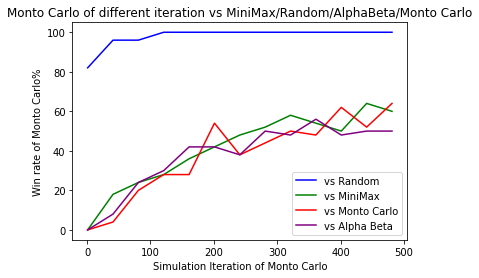

In [213]:
# Create a plot with a caption, X and Y legends, etc
x_label = 'Simulation Iteration of Monto Carlo'
y_label = 'Win rate of Monto Carlo%'
plt.title('Monto Carlo of different iteration vs MiniMax/Random/AlphaBeta/Monto Carlo')
plt.xlabel(x_label)
plt.ylabel(y_label)

plt.plot(iteration, win_vs_random*2, color='blue', label='vs Random')
plt.plot(iteration, win_vs_mini*2, color='green', label='vs MiniMax')
plt.plot(iteration, win_vs_monto*2, color='red', label='vs Monto Carlo')
plt.plot(iteration, win_vs_alpha*2, color='purple', label='vs Alpha Beta')
plt.legend()

plt.show()



In [9]:
#Alpha Beta vs Random/MiniMax/Monto Carlo/Alpha Beta
#evaluation = "advanced", 30 fights
a_depth = np.array([i for i in range(1, 6)])
%time m_win_vs_random = np.array([Connect4_Game(random_player(), alpha_beta_player(depth=ite), 30).play("player2") for ite in a_depth])
%time m_win_vs_mini = np.array([Connect4_Game(minimax_player(), alpha_beta_player(depth=ite), 30).play("player2") for ite in a_depth])
%time m_win_vs_monto = np.array([Connect4_Game(monte_carlo_player(), alpha_beta_player(depth=ite), 30).play("player2") for ite in a_depth])
%time m_win_vs_alpha = np.array([Connect4_Game(alpha_beta_player(),alpha_beta_player(depth=ite), 30).play("player2") for ite in a_depth])


27
29
30
30
30
CPU times: user 16min 23s, sys: 2.94 s, total: 16min 26s
Wall time: 17min 8s
4
6
13
12
12
CPU times: user 17min 33s, sys: 2.04 s, total: 17min 35s
Wall time: 18min 54s
2
13
16
19
24
CPU times: user 39min 55s, sys: 13.2 s, total: 40min 9s
Wall time: 2h 25min 13s
1
9
13
12
16
CPU times: user 27min 19s, sys: 4.7 s, total: 27min 23s
Wall time: 27min 50s


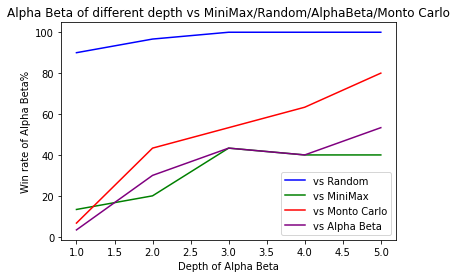

In [10]:
# Create a plot with a caption, X and Y legends, etc
m_x_label = 'Depth of Alpha Beta'
m_y_label = 'Win rate of Alpha Beta%'
plt.title('Alpha Beta of different depth vs MiniMax/Random/AlphaBeta/Monto Carlo')
plt.xlabel(m_x_label)
plt.ylabel(m_y_label)

plt.plot(a_depth, m_win_vs_random/30*100, color='blue', label='vs Random')
plt.plot(a_depth, m_win_vs_mini/30*100, color='green', label='vs MiniMax')
plt.plot(a_depth, m_win_vs_monto/30*100, color='red', label='vs Monto Carlo')
plt.plot(a_depth, m_win_vs_alpha/30*100, color='purple', label='vs Alpha Beta')
plt.legend()

plt.show()

In [16]:
#Alpha Beta, evaluation "simple" vs "advanced"
#50 fights

evaluation_vs = Connect4_Game(alpha_beta_player(), alpha_beta_player(evaluation="simple"), 50)
evaluation_vs.play()
print("Simple evaluation vs Advanced evaluation")
print("Use simple evaluation, win {} out of 50".format(evaluation_vs.player1win))
print("Use advanced evaluation, win {} out of 50".format(evaluation_vs.player2win))
print("Draw {} out of 50".format(evaluation_vs.draw))


Simple evaluation vs Advanced evaluation
Use simple evaluation, win 18 out of 50
Use advanced evaluation, win 22 out of 50
Draw 10 out of 50
